#### Import and ENV

In [1]:
import torch.nn as nn
import torch
import torchvision
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms as T
from torchvision.datasets import CIFAR10
from torchmetrics import Accuracy
import importlib
# Local files
import data
importlib.reload(data)
import encoder
importlib.reload(encoder)
import decoder
importlib.reload(decoder)
import main
importlib.reload(main)
import VAE
importlib.reload(VAE)
import training_VAE
importlib.reload(training_VAE)
# Random Seed
torch.manual_seed(0)

In [2]:
# #bsn = [128, 64]
# z_dim= [128, 64, 32, 10,254]
# betas= [0,1,2]
# for i in z_dim:
#     for j in betas:
#         main.main(bottle_neck = i, experiment_type=1, beta=j, n_epoch=30, lr= 0.001)
#         print(f"Experiment 3 Done bottle size: {i} Beta{j}")
#         # main.main(bottle_neck = i, experiment_type=2, beta=j, n_epoch=1)
#         # print(f"Done bottle size: {i} Beta{j}")
#         # main.main(bottle_neck = i, experiment_type=3, beta=j, n_epoch=1)
#         # print(f"Done bottle size: {i} Beta{j}")

## **DataLoader**

In [27]:
# from data import get_datasets,dataset_to_dataloader
train_ds, val_ds, test_ds = data.get_datasets()
dataloader_train = data.dataset_to_dataloader(train_ds,batch_size = 64)
dataloader_test = data.dataset_to_dataloader(test_ds, batch_size = 64)
dataloader_val = data.dataset_to_dataloader(val_ds, batch_size = 64)

Files already downloaded and verified
Files already downloaded and verified


## **AutoEncoder Model**

https://github.com/SashaMalysheva/Pytorch-VAE

## **Training** 

In [28]:
z_dim = 512
latent_dim = 128
encoder_ = encoder.resnet18(pretrained=False)
encoder_.avgpool = nn.AdaptiveAvgPool2d((1, 1))
# encoder_.fc = nn.Linear(in_features=512, out_features=z_dim, bias=True)
encoder_.fc = nn.Identity()

decoder_ = decoder.ResNet18Dec(z_dim=latent_dim)
model = VAE.VAE(encoder_,decoder_,z_dim,latent_dim).to(torch.device('cuda:0'))
PATH = "/home/alisa/DL_AutoEncoder/DL-AutoEncoder/Results/Pretrained_Init_VAE_bn_128_beta_1.pt"
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [29]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        with torch.no_grad():
          for img in tensor:
            for t, m, s in zip(img, self.mean, self.std):
                t.mul_(s).add_(m)
                # The normalize code -> t.sub_(m).div_(s)
          return tensor

In [37]:
class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        with torch.no_grad():
          for img in tensor:
            for t, m, s in zip(img, self.mean, self.std):
                t.sub_(m).div_(s)
                # The unormalize code -> t.mul_(s).add_(m)
          return tensor

In [35]:
from torchvision.utils import make_grid
unorm = UnNormalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2471, 0.2435, 0.2616))

def peek_results(dataloader, model):
  for img,lb in dataloader:
    fig, ax = plt.subplots(figsize=(16,8))
    fig1, ax1 = plt.subplots(figsize=(16,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax1.set_xticks([]); ax1.set_yticks([])
    img_output,mean,var = model(img.cuda())
    # print(mean[0])
    # print(var[0])
    img_output = img_output.cpu()
    print(img_output.size())
    ax.imshow(make_grid(unorm(img_output), nrow=16).permute(1,2,0))
    #ax.imshow(make_grid(img_output, nrow=16).permute(1,2,0))
    ax1.imshow(make_grid(unorm(img), nrow=16).permute(1,2,0))
    break


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 32, 32])


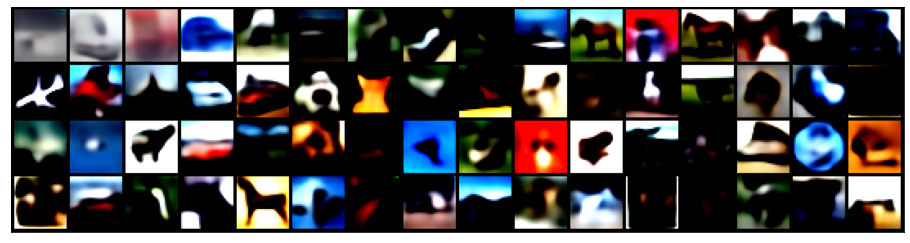

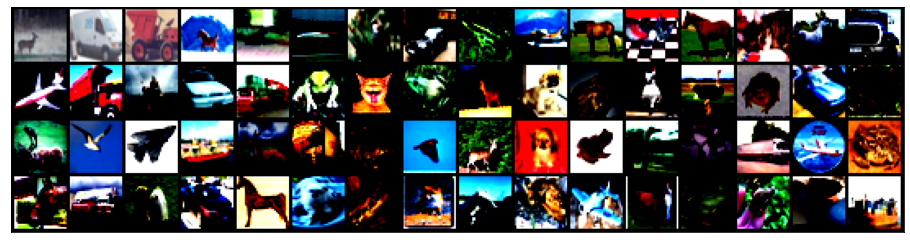

In [36]:
peek_results(dataloader_test, model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[0.78668548 0.15188884 0.63996448 ... 0.30346848 0.55107671 0.76404349]
 [0.769286   0.42173454 0.4327112  ... 0.73878637 0.46909309 0.37421781]
 [0.12247287 0.16051131 0.78831326 ... 0.56948226 0.75517523 0.09196944]
 ...
 [0.54884147 0.5178402  0.49488132 ... 0.87664363 0.87758677 0.45464978]
 [0.05250394 0.66256653 0.40263438 ... 0.96863513 0.61720966 0.97447295]
 [0.00462881 0.95108801 0.31688417 ... 0.00555922 0.29232682 0.7516683 ]]
tensor([[[[-1.9338, -1.9433, -1.9306,  ..., -2.1175, -1.9046, -1.8258],
          [-1.9793, -1.9467, -1.9000,  ..., -2.6372, -2.8714, -2.6464],
          [-1.9405, -1.9290, -1.9156,  ..., -1.5930, -1.7585, -1.7643],
          ...,
          [-1.5067, -1.4491, -1.4141,  ..., -1.6512, -1.6925, -1.7452],
          [-1.7614, -1.6906, -1.5997,  ..., -1.7406, -1.7676, -1.8390],
          [-1.7678, -1.7378, -1.7024,  ..., -1.7795, -1.7732, -1.7085]],

         [[-1.7387, -1.7589, -1.7360,  ..., -0.4636, -0.3663, -0.6495],
          [-1.7674, -1.7864, -1.742

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

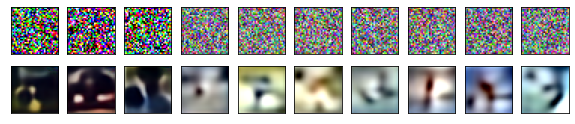

In [17]:
import matplotlib.pyplot as plt
# Convert the predictions into images
num_samples = 10
img_size = 32 
lat_vec_ = np.random.random((num_samples, 3 ,img_size, img_size))
lat_vec_[0][0] = np.random.random((img_size, img_size))
print(lat_vec_[0][0])
random_latent_vectors  = torch.tensor((lat_vec_), dtype=torch.float32)
random_latent_vectors  = torch.tensor(np.random.random((num_samples, 3 ,img_size, img_size)), dtype=torch.float32)

norm = Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2471, 0.2435, 0.2616))
random_latent_vectors = norm(random_latent_vectors)
decoded_imgs,_,_ = model(random_latent_vectors.cuda())
decoded_imgs = unorm(decoded_imgs).cpu().detach()
print(decoded_imgs)
# Display the original and reconstructed images
n = 10 # number of images to display
plt.figure(figsize=(10,2))
for i in range(n):
    # Display the original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(random_latent_vectors[i].permute(1,2,0))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display the reconstructed image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].permute(1,2,0))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()